In [2]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [1029]:
# Physical Constants
q = 1.6 * 10**(-19) # [C]
hbar = 1.054571817e-34 # [J s]
# hbar = 6.582e-16 # [eV s]
T = 300 # [K]
kb = 1.38e-23 # [J/K]
# kb=8.6173303e-5 # [eV/K]
m0 = 9.1e-31 # [kg]
# m0 = 9.1e-34

# Material Constants
u = 1e5  # Mobility [m^2/(V s)]
meff = 0.54*m0
DOS = meff/(np.pi*(hbar)**2)  # 2D DOS step
eps_0 = 8.85*10**(-12) # [F/m]
Ec = 2  # [eV]
mv_t = np.sqrt(2*kb*T/(np.pi*meff)) # [m/s]
# mv_t = 1e5 # [m/s]

# Device Setup
W = 2e-6 # Channel Width in [m]
L = 8e-9 # Channel Length in [m]

eps_bot = 3.8*eps_0 # SiO2 permitivity
b_thic = 300e-9 # SiO2 thickness
Cbox = eps_bot / b_thic
Ctox = 0

m_n_nint = 1e17 # [m-2] initial carrier density

In [1042]:
def theta(x):
    return 1 if x >= 0 else 0

def Cquantum(S=1): # Quantum capacitance per unit area for 2DES with parabolic dispersion [F/m^2]
    return S*meff*q**2/(np.pi*hbar**2)

def V_ch(Vgate, V_t, Cgate=1, Cquant=1, C=1):
    # print("Cgate: ", Cgate)
    # print("Cquant: ", Cquant)
    # print("Vgate", Vgate)
    # print("V_t", V_t)
    val = 2*Cgate/(2*Cgate + Cquant)
    # print("val", val)
    # return 4*val * (Vgate - V_t)
    return C * (Vgate - V_t)

def V_dseff(Vds, beta):
    return (1-beta)*Vds

def sigma_p(Ef, p=0):
    def expression(x, Ef): # Integration over energies in eV
        kbT = (kb * T) / np.abs(q)
        if x < Ef:
            return  theta(x - Ec)* np.power(x,p) / (1 + np.exp((x - Ef) / (kbT)))
        else:
            return theta(x - Ec)*np.power(x,p) * np.exp(-(x - Ef) / (kbT)) / (1 + np.exp(-(x- Ef) / (kbT)))
    result = integrate.quad(expression, 0, np.inf, args=(Ef))
    return result[0]

def I_dc(r, sigma_Vdc, sigma, v_inj):
    if sigma == 0:
        if sigma_Vdc == 0:
            return 0
    # return 2* W * q * DOS * v_inj * sigma * ((1-r)*(1-sigma_Vdc/sigma))
    return 2* q * DOS * v_inj * sigma * ((1-r)*(1-sigma_Vdc/sigma)) * 6.24 * 1e18# [A/m] <--- DOS conversion to [m^-2 eV^-1] !!!
    # return sigma * ((1-r)*(1-sigma_Vdc/sigma))

# $I_{DS}(V_{BG})$

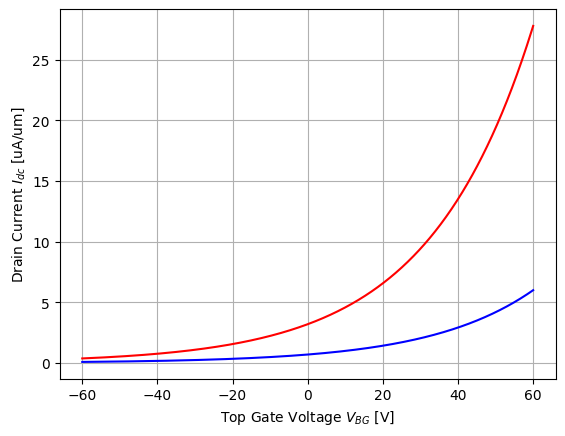

In [1043]:
V_t = 0 # Threshold Voltage [V]
Vdc = 0.1 # DC Voltage [V]
r = 0.99 # Reflection Coefficient
beta = 0.95 # Effective Voltage coefficient
V_gate = np.linspace(-60, 60, 1000)
C_fit = 3*Cbox/(2*Cbox + Cquantum())


def Ids_Vbg(V_gate, Vdc, V_t, r, beta, C_fit):
    mVch = np.array([V_ch(Vgate, V_t, Cbox, Cquantum(), C_fit) for Vgate in V_gate])
    Vdceff = V_dseff(Vdc, beta)
    msigma = np.array([sigma_p(Ef, p=0) for Ef in mVch])
    msigma_Vdc = np.array([sigma_p(Ef, p=0) for Ef in mVch - Vdceff])
    mIdc = np.array([I_dc(r, sigma_Vdc, sigma, mv_t) for sigma_Vdc, sigma in zip(msigma_Vdc, msigma)])  
    return mIdc

mIdc1 = Ids_Vbg(V_gate, Vdc, V_t, r, beta, C_fit=C_fit)
mIdc2 = Ids_Vbg(V_gate, 0.02, V_t, r, beta, C_fit=C_fit)
mIdc3 = Ids_Vbg(V_gate, 0, V_t, r, beta, C_fit=C_fit)

plt.plot(V_gate, mIdc1, "red")
plt.plot(V_gate, mIdc2, "blue")
# plt.plot(V_gate, mIdc3*1e6/W, "green")
# plt.yscale("log")
plt.xlabel(r"Top Gate Voltage $V_{BG}$ [V]")
plt.ylabel(r"Drain Current $I_{dc}$ [uA/um]")
plt.grid()

# print(mVch)


# $I_{DS}(V_{DS})$

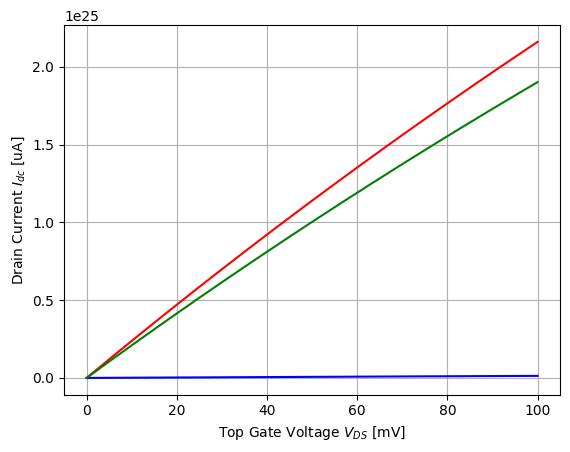

In [1044]:
V_t = -28 # Threshold Voltage [V]
Vds = np.linspace(0, 0.1, 1000) # DC Voltage [V]
r = 0.988 # Reflection Coefficient
beta = 0.943 # Effective Voltage coefficient
V_gate = 60
A = 1.19e23
C_fit = 0.0011

def Ids_Vds(V_gate, Vapp, V_t, r, beta, A=1, C_fit=1):
    Vds = np.array([V_dseff(V, beta) for V in Vapp])
    mVch = V_ch(V_gate, V_t, Cbox, Cquantum(), C=C_fit)
    msigma = sigma_p(mVch, p=0)
    msigma_Vdc = np.array([sigma_p(Ef, p=0) for Ef in mVch - Vds])
    mIdc = np.array([I_dc(r, sigma_Vdc, msigma, mv_t) for sigma_Vdc in msigma_Vdc])  
    return A*mIdc

mIdc1 = Ids_Vds(V_gate, Vds, V_t, r, beta, A, C_fit)
mIdc2 = Ids_Vds(-60, Vds , V_t, r, beta, A, C_fit)
mIdc3 = Ids_Vds(57, Vds , V_t, r, beta, A, C_fit)

plt.plot(Vds*1000, mIdc1, "red")
plt.plot(Vds*1000, mIdc2, "blue")
plt.plot(Vds*1000, mIdc3, "green")
# plt.yscale("log")
plt.xlabel(r"Top Gate Voltage $V_{DS}$ [mV]")
plt.ylabel(r"Drain Current $I_{dc}$ [uA]")
plt.grid()


In [1045]:
import csv
import os

In [1046]:
def read_csv(filename):
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader)
        return np.array([np.array([float(row[0]), float(row[1])]) for row in reader])

b_path = os.path.join("C:/Users/nsemenov/Desktop/SolidStateDevices_FinalProject", 'Vbf_black.csv')
black_curve = read_csv(b_path)
p_path = os.path.join("C:/Users/nsemenov/Desktop/SolidStateDevices_FinalProject", 'Vbf_purple.csv')
purple_curve = read_csv(p_path)

ValueError: x and y must have same first dimension, but have shapes (1,) and (1000,)

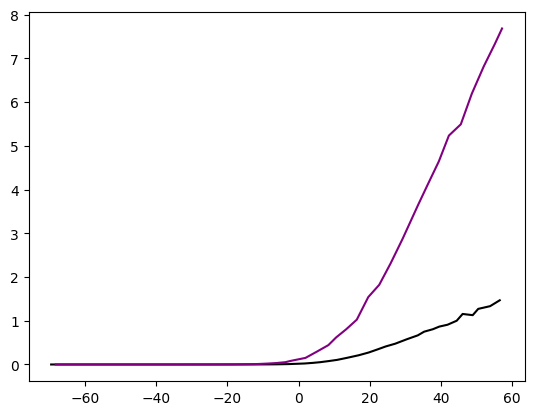

In [1047]:
plot = plt.plot(black_curve[:,0], black_curve[:,1], "black")
plt.plot(purple_curve[:,0], purple_curve[:,1], "purple")
plt.plot(V_gate, mIdc1 , "red")
plt.plot(V_gate, mIdc2, "blue")
# plt.yscale("log")
plt.legend(["Vds = 20 mV", "Vds = 100 mV"], loc="upper left")
plt.xlabel(r"Back Gate Voltage $V_{BG}$ [V]")
plt.ylabel(r"Drain Current $I_{DC}$ [uA/um]")
plt.grid()
plt.savefig("real_VbG_lin.png", dpi=300, bbox_inches='tight')
plt.show()


In [1048]:
lin_path = os.path.join("C:/Users/nsemenov/Desktop/SolidStateDevices_FinalProject", 'Vds_all.csv')
lin_curve = read_csv(lin_path)

[-0.28409091  0.0239521 ] red
[99.52651515  8.05988024] orange
[99.33712121  5.46107784] black
[99.24242424  2.2994012 ] green
[99.33712121  0.35928144] blue
[ 9.91477273e+01 -1.19760479e-02] purple


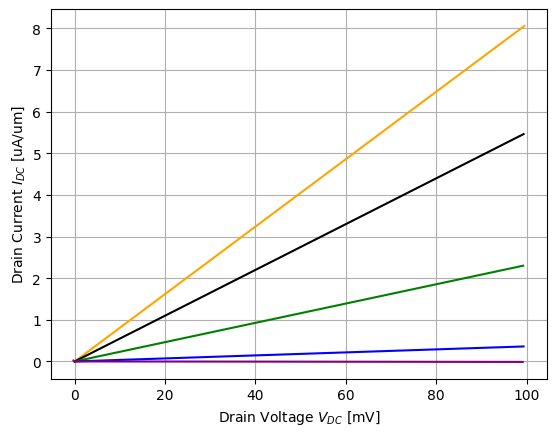

In [1049]:
colors = ["red", "orange", "black", "green", "blue", "purple"]
for each, col in zip(lin_curve, colors):
    print(each, col)
    plt.plot([0, each[0]], [0, each[1]], col)
plt.xlabel(r"Drain Voltage $V_{DC}$ [mV]")
plt.ylabel(r"Drain Current $I_{DC}$ [uA/um]")
plt.grid()
plt.savefig("real_Vds.png", dpi=300, bbox_inches='tight')
plt.show()

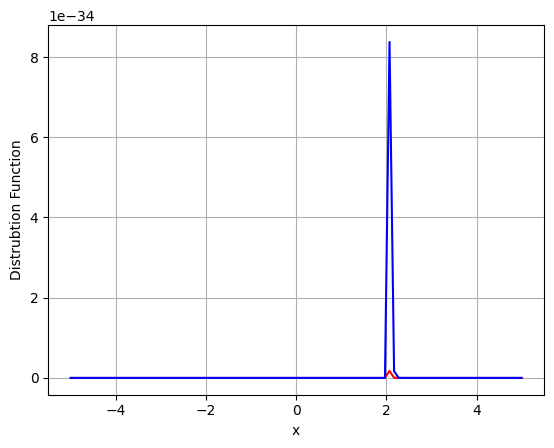

In [1050]:
def f0_int(x, Ef, p=0): # Integration over energies in eV
    kbT = (kb * T) / q
    if x < Ef:
        return  theta(x-Ec)* np.power(x,p) / (1 + np.exp((x - Ef) / (kbT)))
    else:
        return theta(x-Ec)*np.power(x,p) * np.exp(-(x - Ef) / (kbT)) / (1 + np.exp(-(x- Ef) / (kbT)))
    # result = integrate.quad(expression, 0, np.inf, args=(Ef))
    # return result[0]


x0 = np.linspace(-5, 5, 100)
y0 = np.array([f0_int(x, 0) for x in x0])
y1 = np.array([f0_int(x, 0+0.1) for x in x0])
th = np.array([theta(x-Ec) for x in x0])

plt.plot(x0, y0, "red")
plt.plot(x0, y1, "blue")
# plt.plot(x0, th, "green")
# plt.plot(x0, y2, "green")
# plt.plot(x0, (1- y1 / y0)/(1+ y1 / y0), "orange")
# plt.plot(x0, (1- y2 / y0)/(1+ y2 / y0), "purple")
# plt.plot(x0, y2, "green")
plt.xlabel(r"x")  
plt.ylabel(r"Distrubtion Function")
plt.grid()

# Fitting

In [1051]:
from scipy.optimize import curve_fit

pfit A:  0.7899495620285124
pfit_V_t:  11.245
pfit r:  0.8425663853204427
pfit beta:  0.9987322158024099
pfit C:  0.0011547606660090829


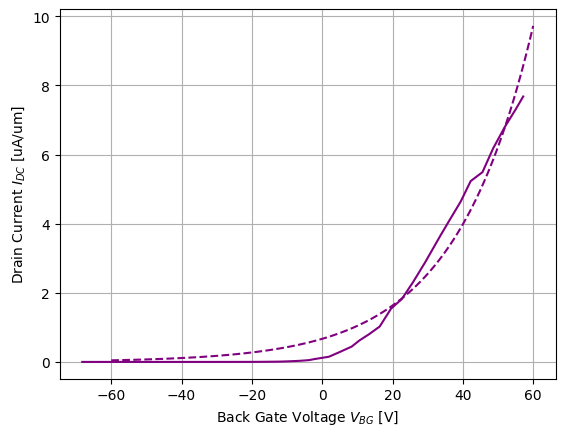

In [1052]:
V_t = 11.245 # Threshold Voltage [V]
Vdc = 0.1 # DC Voltage [V]
r = 0.8 # Reflection Coefficient
beta = 0.95 # Effective Voltage coefficient
V_gate = np.linspace(-60, 60, 1000)
C_fit =  Cbox/(Cbox + Cquantum())
A_gues = 1


def Ids_Vbg_fit(V_gate, A, V_t, r, beta, C_fit):
    mVch = np.array([V_ch(Vgate, V_t, Cbox, Cquantum(), C_fit) for Vgate in V_gate])
    Vdceff = V_dseff(Vdc, beta)
    msigma = np.array([sigma_p(Ef, p=0) for Ef in mVch])
    msigma_Vdc = np.array([sigma_p(Ef, p=0) for Ef in mVch - Vdceff])
    mIdc = np.array([I_dc(r, sigma_Vdc, sigma, mv_t) for sigma_Vdc, sigma in zip(msigma_Vdc, msigma)])  
    return A* mIdc

mIdc1 = Ids_Vbg_fit(V_gate, A_gues, V_t, r, beta, C_fit)

fit_fun = lambda x, C_fit: Ids_Vbg_fit(x, A_gues, V_t, r, beta, C_fit)
lin_fit = lambda x, C_fit, V_t: C_fit*(x - V_t)
no_A = lambda x, r, beta, C_fit: Ids_Vbg_fit(x, A_gues, V_t, r, beta, C_fit)
no_V = lambda x, A, r, beta, C_fit: Ids_Vbg_fit(x, A, V_t, r, beta, C_fit)

initial_guess = [A_gues, V_t, r, beta, C_fit]
# popt, pcov = curve_fit(Ids_Vbg_fit, purple_curve[:,0], purple_curve[:,1], p0=initial_guess)
popt, pcov = curve_fit(no_V, purple_curve[:,0], purple_curve[:,1], p0=[A_gues, r, beta, C_fit])
# popt, pcov = curve_fit(no_A, purple_curve[:,0], purple_curve[:,1], p0=[r, beta, C_fit])
# popt, pcov = curve_fit(lin_fit, purple_curve[-10:-1,0], purple_curve[-10:-1,1], p0=[0.0019, V_t])
# popt, pcov = curve_fit(fit_fun, purple_curve[:,0], purple_curve[:,1], p0=[C_fit])
# Extracting fitted parameters
# pfitted_r, pfitted_beta, pfitted_C = popt
# pfitted_A, pfitted_V_t, pfitted_r, pfitted_beta, pfitted_C = popt
pfitted_A, pfitted_r, pfitted_beta, pfitted_C = popt
# pfitted_C, pfitted_V_t = popt
# pfitted_C = popt
# pfit_Idc = Ids_Vbg_fit(V_gate, pfitted_A, pfitted_V_t, pfitted_r, pfitted_beta, pfitted_C)
pfit_Idc = no_V(V_gate, pfitted_A, pfitted_r, pfitted_beta, pfitted_C)
# pfit_Idc = no_A(V_gate, pfitted_r, pfitted_beta, pfitted_C)
# pfit_Idc = fit_fun(V_gate, pfitted_C)
# pfit_Idc = lin_fit(V_gate, pfitted_C, pfitted_V_t)
print("pfit A: ", pfitted_A)
# print("pfit V_t: ", pfitted_V_t)
print("pfit_V_t: ", V_t)
print("pfit r: ", pfitted_r)
print("pfit beta: ", pfitted_beta)
print("pfit C: ", pfitted_C)
plt.plot(V_gate, pfit_Idc, "--", color="purple")
# plt.plot(V_gate, mIdc1, "red")



plt.plot(purple_curve[:,0], purple_curve[:,1], "purple")
plt.xlabel(r"Back Gate Voltage $V_{BG}$ [V]")
plt.ylabel(r"Drain Current $I_{DC}$ [uA/um]")
plt.grid()
plt.show()

In [1059]:
Cbox*(1-pfitted_C)/pfitted_C

0.09696429279698002

fit A:  0.7783139972612234
fit_V_t:  11.248
fit r:  0.801412755386313
fit beta:  0.999070984953585
fit C:  0.0011972945114725943


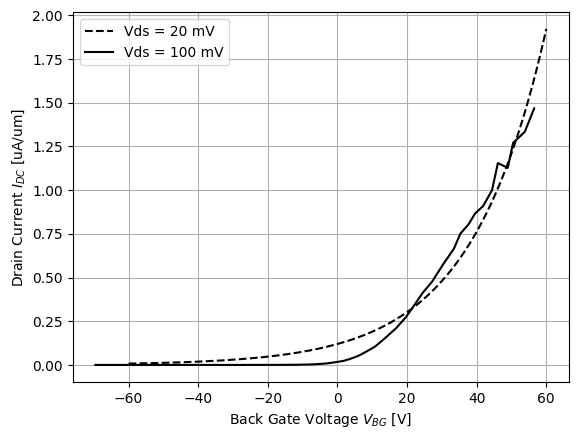

In [1072]:
V_t = 11.248 # Threshold Voltage [V]
Vdc = 0.02 # DC Voltage [V]
r = 0.75 # Reflection Coefficient
beta = 0.95 # Effective Voltage coefficient
V_gate = np.linspace(-60, 60, 1000)
C_fit = Cbox/(Cbox + Cquantum())
A_gues = 1


def Ids_Vbg_fit(V_gate, A, V_t, r, beta, C_fit):
    mVch = np.array([V_ch(Vgate, V_t, Cbox, Cquantum(), C_fit) for Vgate in V_gate])
    Vdceff = V_dseff(Vdc, beta)
    msigma = np.array([sigma_p(Ef, p=0) for Ef in mVch])
    msigma_Vdc = np.array([sigma_p(Ef, p=0) for Ef in mVch - Vdceff])
    mIdc = np.array([I_dc(r, sigma_Vdc, sigma, mv_t) for sigma_Vdc, sigma in zip(msigma_Vdc, msigma)])  
    return A* mIdc

mIdc1 = Ids_Vbg_fit(V_gate, A_gues, V_t, r, beta, C_fit)

no_V = lambda x, A, r, beta, C_fit: Ids_Vbg_fit(x, A, V_t, r, beta, C_fit)

initial_guess = [A_gues, V_t, r, beta, C_fit]
# popt, pcov = curve_fit(Ids_Vbg_fit, black_curve[:,0], black_curve[:,1], p0=initial_guess)
popt, pcov = curve_fit(no_V, black_curve[:,0], black_curve[:,1], p0=[A_gues, r, beta, C_fit])
# Extracting fitted parameters
# fitted_A, fitted_V_t, fitted_r, fitted_beta, fitted_C = popt
fitted_A, fitted_r, fitted_beta, fitted_C = popt
# fit_Idc = Ids_Vbg_fit(V_gate, fitted_A, fitted_V_t, fitted_r, fitted_beta, fitted_C)
fit_Idc = no_V(V_gate, fitted_A, fitted_r, fitted_beta, fitted_C)
print("fit A: ", fitted_A)
# print("fit V_t: ", fitted_V_t)
print("fit_V_t: ", V_t)
print("fit r: ", fitted_r)
print("fit beta: ", fitted_beta)
print("fit C: ", fitted_C)
plt.plot(V_gate, fit_Idc, "--", color="black")


plot = plt.plot(black_curve[:,0], black_curve[:,1], "black")
# plt.plot(V_gate, mIdc1, "red")
# plt.yscale("log")
plt.legend(["Vds = 20 mV", "Vds = 100 mV"], loc="upper left")
plt.xlabel(r"Back Gate Voltage $V_{BG}$ [V]")
plt.ylabel(r"Drain Current $I_{DC}$ [uA/um]")
plt.grid()
plt.savefig("real_VbG_lin.png", dpi=300, bbox_inches='tight')
plt.show()

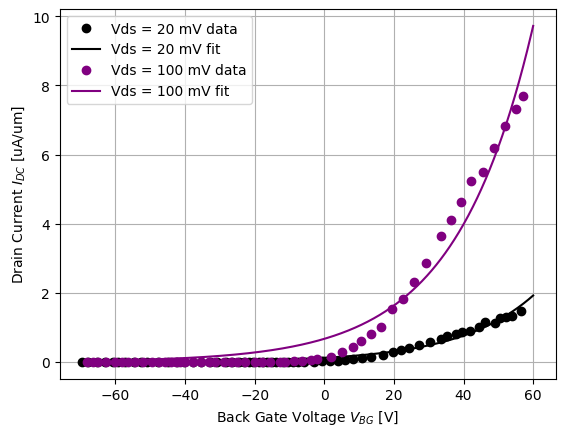

In [1087]:
plot = plt.plot(black_curve[:,0], black_curve[:,1], "o", color="black")
plt.plot(V_gate, fit_Idc, color="black")
plt.plot(purple_curve[:,0], purple_curve[:,1], "o", color="purple")
plt.plot(V_gate, pfit_Idc, color="purple")
plt.legend(["Vds = 20 mV data", "Vds = 20 mV fit", "Vds = 100 mV data", "Vds = 100 mV fit"], loc="upper left")
plt.xlabel(r"Back Gate Voltage $V_{BG}$ [V]")
plt.ylabel(r"Drain Current $I_{DC}$ [uA/um]")
plt.grid()
plt.savefig("fit_Vbg.png", dpi=300, bbox_inches='tight')
plt.show()

[99.52651515  8.05988024] orange
[99.33712121  5.46107784] black
[99.24242424  2.2994012 ] green
[99.33712121  0.35928144] blue
[ 9.91477273e+01 -1.19760479e-02] purple


C:\Users\nsemenov\AppData\Local\Temp\ipykernel_31976\3008767145.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, each[0]], [0, each[1]], 'ro', color=col, linewidth=0.5)


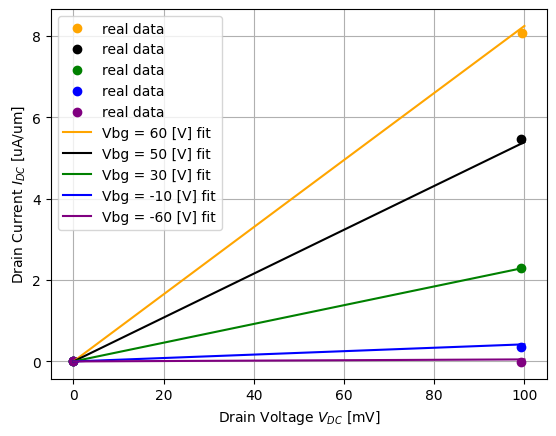

In [1096]:
colors = ["red", "orange", "black", "green", "blue", "purple"]
for each, col in zip(lin_curve[1:], colors[1:]):
    print(each, col)
    plt.plot([0, each[0]], [0, each[1]], 'ro', color=col, linewidth=0.5)

V_t = 11.248 # Threshold Voltage [V]
Vds = np.linspace(0, 0.1, 1000) # DC Voltage [V]
r = 0.81 # Reflection Coefficient
beta = 0.999 # Effective Voltage coefficient
V_gate = 60
A = 0.78
C_fit = 0.0011

def Ids_Vds(V_gate, Vapp, V_t, r, beta, A=1, C_fit=1):
    Vds = np.array([V_dseff(V, beta) for V in Vapp])
    mVch = V_ch(V_gate, V_t, Cbox, Cquantum(), C=C_fit)
    msigma = sigma_p(mVch, p=0)
    msigma_Vdc = np.array([sigma_p(Ef, p=0) for Ef in mVch - Vds])
    mIdc = np.array([I_dc(r, sigma_Vdc, msigma, mv_t) for sigma_Vdc in msigma_Vdc])  
    return A*mIdc

mIdc1 = Ids_Vds(V_gate, Vds, V_t, r, beta, A, C_fit)
mIdc2 = Ids_Vds(50, Vds , V_t, r, beta, A, C_fit)
mIdc3 = Ids_Vds(30, Vds , V_t, r, beta, A, C_fit)
mIdc4 = Ids_Vds(-10, Vds , V_t, r, beta, A, C_fit)
mIdc5 = Ids_Vds(-60, Vds , V_t, r, beta, A, C_fit)

plt.plot(Vds*1000, mIdc1, color="orange")
plt.plot(Vds*1000, mIdc2, color="black")
plt.plot(Vds*1000, mIdc3, color="green")
plt.plot(Vds*1000, mIdc4, color="blue")
plt.plot(Vds*1000, mIdc5, color="purple")

plt.legend(["real data", "real data", "real data", "real data", "real data", "Vbg = 60 [V] fit", "Vbg = 50 [V] fit", "Vbg = 30 [V] fit", "Vbg = -10 [V] fit", "Vbg = -60 [V] fit",], loc="upper left")



plt.xlabel(r"Drain Voltage $V_{DC}$ [mV]")
plt.ylabel(r"Drain Current $I_{DC}$ [uA/um]")
plt.grid()
plt.savefig("fit_Vds.png", dpi=300, bbox_inches='tight')
plt.show()

# Fitting analysis

In [1057]:
A_mean = (fitted_A + pfitted_A)/2

In [543]:
C_mean = (fitted_C + pfitted_C)/2

In [549]:
b_mean = (fitted_beta + pfitted_beta)/2

In [548]:
2*Cbox/(2*Cbox + Cquantum())

0.00062228931523798

In [552]:
b_mean * 0.1/8e-6

11795.624140522119

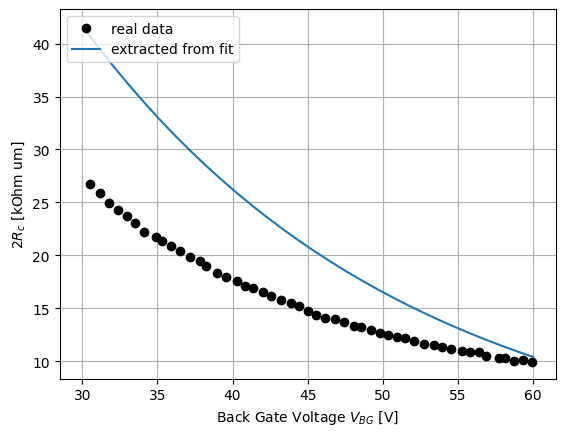

In [1090]:
b_mean = (fitted_beta + pfitted_beta)/2

Rc_real_path = os.path.join("C:/Users/nsemenov/Desktop/SolidStateDevices_FinalProject", '2Rc_real_data.csv')
Rc_real = read_csv(Rc_real_path)
plt.plot(Rc_real[:,0], Rc_real[:,1], 'o', color="black")

R_c = []
V_bg_list = np.linspace(30, 60, 30)
for each in V_bg_list:
    cur = Ids_Vds(each, Vds, V_t, fitted_r, fitted_beta, fitted_A, fitted_C)
    # print(cur)
    R_c.append(np.mean((b_mean * Vds[1:] / (cur[1:] * 1e-6) / 1000)))

plt.plot(V_bg_list, R_c)
plt.legend(["real data", "extracted from fit"], loc="upper left")
plt.xlabel(r"Back Gate Voltage $V_{BG}$ [V]")
plt.ylabel(r"$2R_{c}$ [kOhm um]")
plt.grid()
plt.savefig("fit_Rc.png", dpi=300, bbox_inches='tight')
plt.show()

In [1080]:
Cbox * (1- fitted_C)/fitted_C

0.09351565735280393

In [1014]:
test_r = 0.84
mv_t * q * (L - L*test_r) / (2 * kb * T * test_r) * 10000

21.56467838279799

In [1081]:
Cquantum()

0.36005837999940093

In [586]:
7.6e4

76000.0

In [705]:
kb*T/q

0.025875

In [784]:
fitted_A

1.0124422056780858e+22

In [1083]:
3* kb * T / q

0.07762499999999999